### Bayesian Statistics, Markov-Chain Monte Carlo, and PyMC

#### July 8, 2019

Before you do imports you need to install pymc3. Try using conda, like this:

`conda install -c conda-forge pymc3`

N.B. There's some bad interaction between recent versions of MacOS and the back-end library Theano; doing something like

`open /Library/Developer/CommandLineTools/Packages/macOS_SDK_headers_for_macOS_10.14.pkg`

might help.

Also do `pip install arviz`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
from scipy import stats
import pymc3 as pm
%matplotlib inline

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Objectives

 * Discuss the different ways of estimating posteriors with an infinite number of hypotheses.
 * Describe sampling a posterior using Markov-chain Monte Carlo.
 * Build a simple model with `pymc` and calculate a trace.

Earlier we talked a bit about Bayesian statistics. To review:

Suppose we're considering some hypothesis $H$ and we've collected some data $\mathbf{X}$.
$$ P(H|\mathbf{X}) = \frac{P(\mathbf{X}|H) P(H)}{P(\mathbf{X})} $$

Each term has a name.

* $P(H)$ is the *prior probability*
* $P(\mathbf{X}|H)$ is the *likelihood*.
* $P(\mathbf{X})$ is the *normalizing constant*.
* $P(H|\mathbf{X})$ is the *posterior probability*.


If there are a bunch of hypotheses $H_1, H_2, ... H_n$ (that we assume *partition* the sample space, so exactly one of them is true), we could write this as

$$\begin{align}
P(H_i|\mathbf{X}) & = \frac{P(\mathbf{X}|H_i) P(H_i)}{P(\mathbf{X})}\\
         & = \frac{P(\mathbf{X}|H_i) P(H_i)}{\sum_{j} P(\mathbf{X}|H_j) P(H_j)}
\end{align}
$$

Here we see the normalizing constant is the likelihood times the prior summed over all possible hypothesis. In other words, it's the constant (independent of hypothesis) we need to divide all the numerators by so they all add up to one.

When you worked that out computationally you saw calculating the normalizing constant was difficult, particularly in cases with an infinite number of possible hypotheses. One approach we took was to use conjugate priors. That's fine for click-through rates but is only available for simple models. The other is to divide the hypothesis space into many slices, but that becomes computationally impossible in high-dimensional space. In particular, that means giving the same attention to areas that are likely in the posterior as those that are almost impossible.

A third choice is random sampling. We call this a *Monte-Carlo* approach. In particular we sample many points (hypotheses) from the posterior distribution, transitioning from each point to the next, in what is called Markov-Chain Monte Carlo (MCMC). There are a number of different approaches to this; a common one, called the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, works like this.

First, we start at a given set of point (hypothesis). We then adjust the parameters slightly (in such way that the probabilities are symmetric) and consider a new point. If it has a higher value for the pdf of the posterior, we accept it automatically. If it's lower, we accept it with a probability of the fraction of the ratio with the pdf at the current point. Otherwise  we reject the new point. We repeat this many, many times.

Let's try this out to sample something we already understand, a multivariate normal distribution. We haven't talked about multivariate distributions yet, but they just take non-scalar parameters. This is a two dimensional distribution (because we want to draw it) centered at the origin with a variance of 1 in one direction and 2 in the other.

In [2]:
dist = stats.multivariate_normal([0, 0], [[2, 0], [0, 1]])

We also need a starting position; let's start with the origin. We're going to keep track of all successful steps in a list.

In [3]:
current = np.array([0, 0])
steps = [current]

And we need another distribution to randomly general possible steps. We'll use a normal distribution for this too, but a bit smaller.

In [4]:
step_generator = stats.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]])

Now we'll generate a new position, based on the `current` position plus a random step from `step_generator`

In [5]:
new = current + step_generator.rvs()

Now we need to decide whether to "accept" the new position (in which case it becomes the `current`, and we try again from there) or "reject" it (in which case we ignore the `new` position and try again).

We'll accept the new position if
 * the value of the distribution at `new` is greater then that at `current`, or
 * the value at `new` is less, with a probability equal to the ratio of the values.

Note (and this is important) that although here's we're using the pdf, we really just need something proportional to the pdf since we just care about the ratio of the values at different locations.

In [6]:
if dist.pdf(new) > dist.pdf(current) or \
   np.random.rand() < (dist.pdf(new) / dist.pdf(current)):
    print(f"Accept: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")
    current = new
    steps.append(current)
else:
    print(f"Reject: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")

Accept: Current pdf: 0.1125 new pdf 0.0905


Let's put that in a function, and then run it a bunch of times. Since we want to visualize the results we'll keep track of all the rejects as well; ordinarily we can just ignore them.

In [7]:
def consider_step(dist, step_generator, accepted, rejected):
    """Make one step using the Metropolis-hastings algorithm."""
    if len(accepted) > 0:
        current = accepted[-1][1]
    else:
        current = np.array([0, 0])

    new = current + step_generator.rvs()
    if (dist.pdf(new) > dist.pdf(current) or
            np.random.rand() < (dist.pdf(new) / dist.pdf(current))):
        print(f"Accept: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")
        accepted.append((current, new))
    else:
        print(f"Reject: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")
        rejected.append((current, new))

In [8]:
accepted = []
rejected = []

In [9]:
for _ in range(50):
    consider_step(dist, step_generator, accepted, rejected)

Accept: Current pdf: 0.1125 new pdf 0.0939
Accept: Current pdf: 0.0939 new pdf 0.0982
Reject: Current pdf: 0.0982 new pdf 0.0436
Accept: Current pdf: 0.0982 new pdf 0.1111
Accept: Current pdf: 0.1111 new pdf 0.0944
Accept: Current pdf: 0.0944 new pdf 0.0837
Accept: Current pdf: 0.0837 new pdf 0.0975
Accept: Current pdf: 0.0975 new pdf 0.0899
Accept: Current pdf: 0.0899 new pdf 0.0681
Accept: Current pdf: 0.0681 new pdf 0.0969
Reject: Current pdf: 0.0969 new pdf 0.0502
Reject: Current pdf: 0.0969 new pdf 0.0616
Accept: Current pdf: 0.0969 new pdf 0.1061
Reject: Current pdf: 0.1061 new pdf 0.0928
Accept: Current pdf: 0.1061 new pdf 0.1088
Accept: Current pdf: 0.1088 new pdf 0.0999
Accept: Current pdf: 0.0999 new pdf 0.1092
Accept: Current pdf: 0.1092 new pdf 0.0808
Accept: Current pdf: 0.0808 new pdf 0.1051
Reject: Current pdf: 0.1051 new pdf 0.0468
Accept: Current pdf: 0.1051 new pdf 0.1084
Accept: Current pdf: 0.1084 new pdf 0.0654
Reject: Current pdf: 0.0654 new pdf 0.0323
Accept: Cur

Let's graph that, along with ellipses at 1 and 2 standard deviations.

In [10]:
def plot_mcmc_steps(ax, accepted, rejected,
                    show_connections=False,
                    show_rejected=False):
    ax.plot([0], [0], 'go')

    if show_connections:
        for step in accepted:
            ax.plot(*zip(step[0], step[1]), 'b.-', lw=0.5, alpha=0.8)
    else:
        for step in accepted:
            ax.plot(*zip(step[0], step[1]), 'b.', lw=0.5, alpha=0.8)
    if show_rejected:
        for step in rejected:
            ax.plot(*zip(step[0], step[1]), 'r.-', lw=0.5, alpha=0.8)

    ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                             width=4,
                                             height=2,
                                             fill=False,
                                             ec='g',
                                             lw=0.5))
    ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                             width=8,
                                             height=4,
                                             fill=False,
                                             ec='g',
                                             lw=0.5))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-2.5, 2.5)

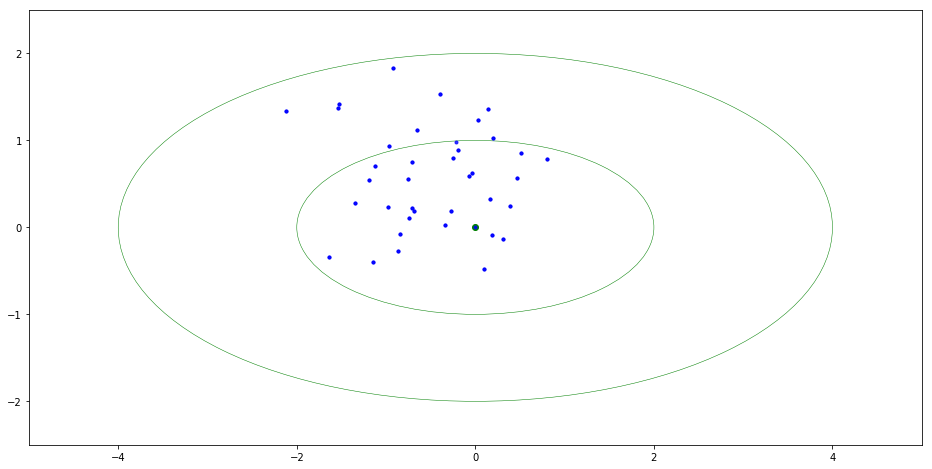

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
# we can change show_connections and show_rejected to understand the process
plot_mcmc_steps(ax, accepted, rejected,
                show_connections=False,
                show_rejected=False)

We can go back and run that longer to gather more data...

The accepted points can be treated as an IID sample from the distribution, and then we can draw conclusions from that (e.g., what's the probability that $x_1 > 2$?)

**Question:** are the points actually IID?

Today most MCMC approaches use more sophisticated algorithms, generally using a similar idea but including momentum. The `pymc3` library uses NUTS (No-U-Turn Sampling) by default.

## Experimenting with pymc

Let's start with the coin-flip/CTR example we've seem a couple times before. In this we have data on successes and failures and we want to determine the value of some unknown click-through rate. First, let's make some fake data!

In [12]:
prob_actual = 0.10
data_ctr = stats.bernoulli(prob_actual).rvs(100, random_state=10)
data_ctr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [13]:
data_ctr.mean()

0.08

The pymc interface uses the `with` statement in python to specify a model with which we'll be operating. The first time we interact with it we'll need to call the constructor and assign it to a variable with `as`; after that we just refer to that variable. Any variables created are added to that model object automatically, and any sampling or optimization is done on that model.

In general, there are a couple different types of variables. First, we can create a variable that represents some prior distribution of a variable. Here we're just starting with a uniform distribution for a prior. Each object created in the model (usually) needs a name so we can identity it later. 

In [14]:
with pm.Model() as model_ctr:
    prob = pm.Uniform('prob', 0, 1)

The other type of variable in the model is a likelihood, specifying the observed data.

In [15]:
with model_ctr:
    observed = pm.Bernoulli('observed', prob, observed=data_ctr)

Now we do some sampling! The result of sampling is often called a *trace*. The initial tuning steps let the algorithm figure out the optimum step size; if there isn't enough tuning the algorithm might make steps that are too big (and hence constantly rejected) or too small (and so take too long to explore the sample space).

In [16]:
with model_ctr:
    trace = pm.sample(5000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prob]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2341.35draws/s]


If the `tune` parameter is set too small we will get a warning here. Simply increase the parameter and try again.

Note that there may be multiple jobs each making its own chain of values (generally, one for each core on the computer).

In [17]:
trace['prob'].shape

(10000,)

The result of `sample` will contain values for all of the variables, distributed (if we have enough) in the same manner as the posterior distribution of those variables. Let's visualize them.

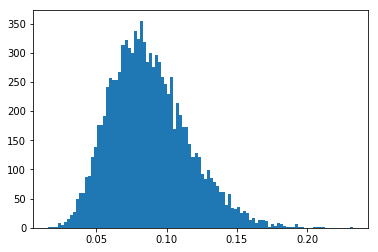

In [18]:
fig, ax = plt.subplots()
ax.hist(trace['prob'], bins=100)
plt.show()

**Questions:**

Why doesn't it peak at the actual value for the probability (`prob_actual`)?

Why isn't this very smooth?

Is this a beta distribution?

**Discussion:** Now that we have this posterior distribution of hypothesis, what can we do with it? (hint: we did this before when we talked about Bayesian statistics)

## A (slightly) harder example

Bernoulli distributions aren't all that exciting. Again, let's use fake data. We'll sample a few points from a normal distribution and try to recover the parameters.

In [19]:
mu_actual = 5
sigma_actual = 2
data = stats.norm(mu_actual, sigma_actual).rvs(10)

What do we have?

In [20]:
print("mean = {:.3f} sd = {:.3f}".format(data.mean(), data.std()))

mean = 4.645 sd = 1.886


For now let's assume we know `sigma`, just to make it easier. We'll take a uniform prior for `mu` but assume it's between 0 and 10.

In [21]:
with pm.Model() as model_normal:
    # prior
    mu = pm.Uniform("mu", 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, 2, observed=data)

We might want to start my calculating the maximum *a posteriori* (MAP) value for the `mu`.

**Question:** what is MAP?

In [22]:
with model_normal:
    estimate = pm.find_MAP()
estimate

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -23.027, ||grad|| = 2.2185: 100%|██████████| 6/6 [00:00<00:00, 895.10it/s]


{'mu_interval__': array(-0.14222213), 'mu': array(4.64504279)}

In [23]:
with model_normal:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:07<00:00, 2639.38draws/s]


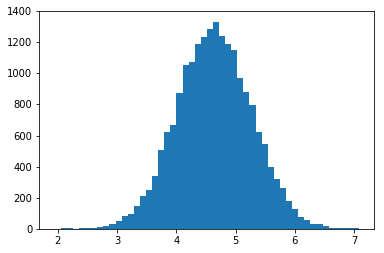

In [24]:
fig, ax = plt.subplots()
ax.hist(trace['mu'], bins=50);

But really we want to estimate both the `mu` and `sigma`. We just need to put both in the model.

In [25]:
with pm.Model() as model_normal2:
    # prior
    mu = pm.Uniform('mu', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, sigma, observed=data)

In [26]:
with model_normal2:
    estimate = pm.find_MAP()

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -25.139, ||grad|| = 0.028108: 100%|██████████| 14/14 [00:00<00:00, 1595.66it/s]  


Are these the right values?

In [27]:
print("                   mu   sigma")
print("MAP estimate      {:5.3f} {:5.3f}".format(float(estimate['mu']), float(estimate['sigma'])))
print("sample statistics {:5.3f} {:5.3f}".format(data.mean(), data.std()))
print("actual            {:5.3f} {:5.3f}".format(mu_actual, sigma_actual))

                   mu   sigma
MAP estimate      4.645 1.886
sample statistics 4.645 1.886
actual            5.000 2.000


In [28]:
with model_normal2:
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1006.64draws/s]


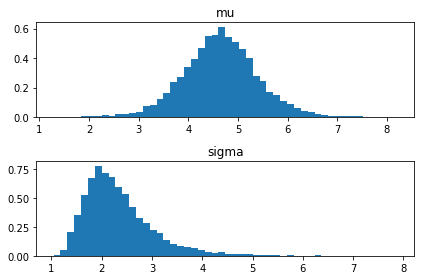

In [29]:
fig, axes = plt.subplots(2)
axes[0].hist(trace['mu'], bins=50, density=True)
axes[1].hist(trace['sigma'], bins=50, density=True)
axes[0].set_title("mu")
axes[1].set_title("sigma")
plt.tight_layout()
plt.show()

There's a function to plot this automatically.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e58cd30>,
      dtype=object)

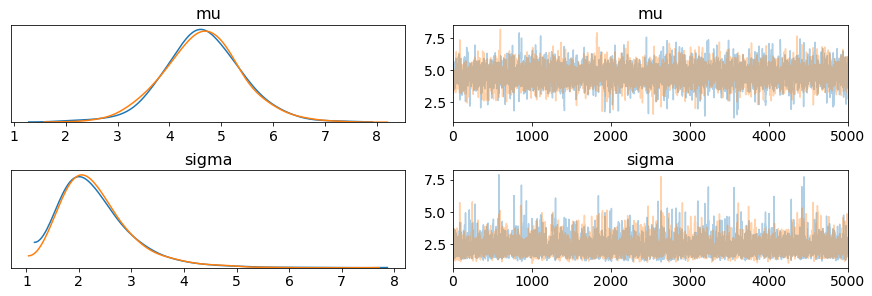

In [30]:
pm.traceplot(trace)

A scatter plot will show us the how they are related.

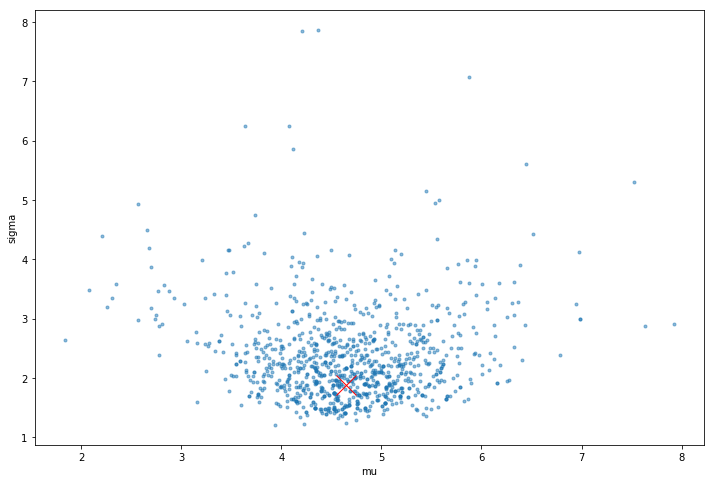

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '.', alpha=0.5)
#ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '-', alpha=0.5)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.plot(data.mean(), data.std(), 'rx', ms=20)

**Question:** Based on this plot, are `sigma` and `mu` independent random variables?

**Question:** Is that what you expect? Why or why not?

## Linear modeling

Suppose we want to do linear regression with `pymc3`. Our model will get a little more complicated. We'll use the boston dataset.

In [32]:
boston_data = sklearn.datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df_boston['target'] = boston_data.target
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [33]:
X = df_boston.values[:, :-1]
y = df_boston.values[:, -1]

We can build the model as before, but this time the observed data includes values for `X` as well as the target.

This model is also different in that `beta` is now an array (`shape=(13,)`) since we have a prior for the coefficient for each feature.

In [34]:
with pm.Model() as model_boston:
    intercept = pm.Normal('intercept', 0, 1e6)
    sd = pm.HalfNormal('sd', 1e6)
    beta = pm.Normal('beta', 0, 1000, shape=(13,))
    observed = pm.Normal('observed',
                         intercept + (beta * X).sum(axis=1),
                         sd,
                         observed=y)

In [35]:
with model_boston:
    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sd, intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:41<00:00, 72.30draws/s] 
The acceptance probability does not match the target. It is 0.9305414416367467, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9198974740151173, but should be close to 0.8. Try to increase the number of tuning steps.


The `pymc` module has a simpler format for linear modeling that abstracts away most of these details. In this case the model is specified with a formula, similar to R (using the `patsy` package also used by `statsmodels`). Here's an example where we just use a single feature (`LSTAT`) rather than all 13. 

In [36]:
with pm.Model() as model_boston_1d:
    pm.glm.GLM.from_formula('target ~ LSTAT', df_boston)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, LSTAT, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1014.30draws/s]
The acceptance probability does not match the target. It is 0.8877076575625524, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898859428778899, but should be close to 0.8. Try to increase the number of tuning steps.


We can plot that out. Since we have the standard deviation, we can show quartile ranges, given by the red dots. Assuming the underlying model really is linear (it's not), there is a 50% chance the actual values of the target will fall between the red dots, considering both the uncertainty of the hypothesis and the error in the model.

(100, 400000)


Text(0.5, 0, '% lower status of the population')

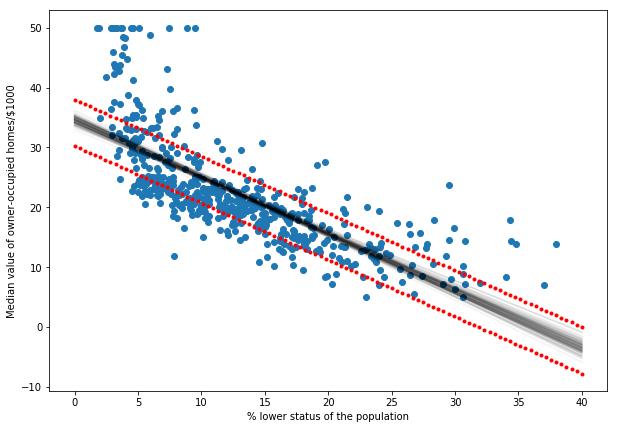

In [37]:
xmin = 0
xmax = 40
n_xpts = 100
n_rnd = 200
fix, ax = plt.subplots(figsize=(10,7))
ax.scatter(df_boston.LSTAT, df_boston.target)
for i, point in enumerate(trace):
    if i%10 == 0:
        ax.plot([xmin, xmax],
                [point['Intercept'] + point['LSTAT']*xmin,
                 point['Intercept'] + point['LSTAT']*xmax],
                'k', alpha=0.05)

xpts = np.linspace(xmin, xmax, n_xpts).reshape(-1, 1, 1)
rnd = stats.norm(0,1).rvs(n_rnd).reshape(-1, 1)
ypts = trace['Intercept'] + xpts * trace['LSTAT'] + rnd*trace['sd']
ypts = ypts.reshape(n_xpts, -1)
xpts = xpts.reshape(-1)
print (ypts.shape)
for xpt, ypt in zip(xpts, ypts):
    ax.plot([xpt], [np.percentile(ypt, 75)], 'r.')
    ax.plot([xpt], [np.percentile(ypt, 25)], 'r.')
ax.set_ylabel("Median value of owner-occupied homes/$1000")
ax.set_xlabel('% lower status of the population')